In [2]:
# install requeird libreries
!pip install mido

# imports
import os
from scipy.special import softmax
import torch
import mido
import numpy as np
import math
import torch.nn as nn
import torch.utils.data as data
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt
#from utils import *
import math
import torch.nn.functional as F

# needed only for MAC
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# creating cude device to run on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))
if str(device) == 'cuda':
  print(torch.cuda.get_device_name())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.4 MB/s eta 0:00:00
device: cuda
NVIDIA A100-SXM4-40GB


In [4]:
!pip install mido pretty_midi
import os
import numpy as np
import pretty_midi  # For processing MIDI files

# creating the vocabulary
vocab = []

# Mount Google Drive
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
#specify the path
path='/content/drive/My Drive/MIDImakeover/'
pieces = {}

for i in os.listdir(path):
  if '.mid' in i:
    midi_data = pretty_midi.PrettyMIDI(path + '/' + i)
    # Convert MIDI to a piano roll (a NumPy array)
    mat = midi_data.get_piano_roll(fs=20)  # fs is frames per second
    mat = (mat > 0).astype(int)  # Binarize velocities
    mat = mat.T  # Transpose to match expected format
    pieces[i] = mat
    l = mat.tolist()

      # convert to array, remove length (was in position 89 at each vector)
      # and set all note velocity to same value
    for row in mat:
        row = np.array(row)
        row[0:88][row[0:88] > 0] = 50
        row = row[0:88]
        vocab.append(str(row.tolist()))

vocab = list(set(vocab))
print('number of unique combination of notes ("words"): '+str(len(vocab)))

# Display the first few items in the vocabulary
print("Number of unique combinations of notes ('words'):", len(vocab))

# Check if the vocabulary is empty
if len(vocab) == 0:
    print("The vocabulary is empty.")
else:
    # Print a few sample items
    print("Sample items from the vocabulary:")
    for idx, word in enumerate(vocab[:10]):  # Adjust the number of items to display as needed
        print(f"{idx + 1}: {word}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
number of unique combination of notes ("words"): 533
Number of unique combinations of notes ('words'): 533
Sample items from the vocabulary:
1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 50, 0, 0, 0, 0, 50, 0, 0, 0, 50, 0, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0]
2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 50, 0, 0, 50, 0, 0, 

In [5]:
# transition dicts from word to vec and back dicts
w2i = {}
i2w = {}
for i, word in enumerate(vocab):
  w2i[word] = i
  i2w[i] = word


In [6]:
class Dataset(torch.utils.data.Dataset):
  """create a torch dataset to load the data into the model during training"""

  def __init__(self, seq_len, n_pieces=250):
    """initiate the dataset"""

    # initate class variables
    self.seq_len = seq_len # length of dequence fed into the model
    self.lengths = {} # number of training examples in each music piece
    self.examlpe_num = 0 # number of total trainig examples in dataset

    # Calculate values for self.lengths and self.examlpe_num
    for piece_name in os.listdir(path)[:n_pieces]:
        if piece_name in pieces:  # This checks if the piece exists in the dictionary
            piece = pieces[piece_name]
            self.lengths[piece_name] = piece.shape[0] - (self.seq_len + 1)
            self.examlpe_num += piece.shape[0] - (self.seq_len + 1)

  def __len__(self):
        'Denotes the total number of samples'
        return self.examlpe_num

  def __getitem__(self, example_idx):
        """retirives a training example given idx"""

        # deduce the piece that contains the index by iterating over their number of training examples
        s = 0
        for piece_check in self.lengths:
          if s + self.lengths[piece_check] > example_idx:
            piece = piece_check
            example_idx -= s
            break
          s += self.lengths[piece_check]

        # load the piece and exctract training example
        piece = pieces[piece]
        x = piece[example_idx:example_idx+self.seq_len,:]
        y = piece[example_idx+1:example_idx+self.seq_len+1,:]

        # convert to array, remove length (was in position 89 at each vector)
        # and set all note velocity to same value
        x[:,0:88][x[:,0:88] > 0] = 50
        y[:,0:88][y[:,0:88] > 0] = 50
        x = x[:,0:88]
        y = y[:,0:88]

        # convert the a list of the words' indexes
        x = [str(j) for j in x.tolist()]
        y = [str(j) for j in y.tolist()]
        x = [w2i[j] for j in x]
        y = [w2i[j] for j in y]

        # convert to tensors, and create one hot encoding to the target words
        x = torch.tensor(x).long()
        y = torch.tensor(y).long()
        y = nn.functional.one_hot(y, num_classes=len(vocab))

        return x, y

In [7]:
class AttentionError(Exception):
    pass

class MultiheadedAttention(nn.Module):
    """
    Narrow multiheaded attention. Each attention head inspects a
    fraction of the embedding space and expresses attention vectors for each sequence position as a weighted average of all (earlier) positions.
    """

    def __init__(self, d_model, sequence_len, heads=8, dropout=0.1):
        """initiate the layer"""
        super().__init__()

        # make sure embedding size is devidable by number of heads
        if d_model % heads != 0:
            raise AttentionError("Number of heads does not divide model dimension")

        # initate class variables
        self.d_model = d_model # embedding size
        self.heads = heads # number of heads
        s = d_model // heads # features per head
        self.linears = []
        for head in range(heads):
          self.linears.append(torch.nn.ModuleList([nn.Linear(s, s, bias=False) for i in range(3)])) # linear layers: WQ, WK and WV
        self.recombine_heads = nn.Linear(heads * s, d_model) # combines heads back to single output of the right size
        self.dropout = nn.Dropout(p=dropout) # dropout layer
        self.Er = torch.randn([s, sequence_len], device=device, requires_grad=True) # relative positinal embedding matrix

    def forward(self, x):
        x_mask = (x != 0)
        mask = x_mask.type(torch.uint8)
        x = x.permute(1,0,2)
        #batch size, sequence length, embedding dimension
        b, t, e = x.size()
        #each head inspects a fraction of the embedded space
        h = self.heads
        #single head dimension
        s = e // h
        # devide input to seperate dim for each head
        x = x.view(b,t,h,s)
        # compute seperate queries, keys and values for each head
        queries, keys, values = [], [], []
        for head in range(self.heads):
          x_head = x[:,:,head,:]
          q, k, v = [w(x) for w, x in zip(self.linears[head].to(device), (x_head,x_head,x_head))]
          queries.append(q)
          keys.append(k)
          values.append(v)

        #apply same position embeddings across the batch
        SRel = []
        for head in range(self.heads):
          QEr = torch.matmul(queries[head], self.Er)
          SRel.append(QEr.contiguous().view(b, t, t))

        #Compute scaled dot-product self-attention
        head_represenations = []
        for head in range(self.heads):
          # scale pre-matrix multiplication for stability
          queries[head] = queries[head] / (e ** (1/4))
          keys[head] = keys[head] / (e ** (1/4))
          # multiply queries by keys
          scores_head = torch.bmm(queries[head], keys[head].transpose(1, 2))
          # add atantion socres to relative positional scores
          scores = scores_head + SRel[head]
          # mask
          subsequent_mask = torch.triu(torch.ones(1, t, t, device=device), 1)
          scores = scores.masked_fill(subsequent_mask == 1, -1e9)
          #Convert scores to probabilities
          attn_probs = F.softmax(scores, dim=2)
          attn_probs = self.dropout(attn_probs)
          #use attention to get a weighted average of values
          head_represenations.append(torch.bmm(attn_probs, values[head]).view(b, t, s))

        out = torch.cat(head_represenations, dim=2)
        #transpose and recombine attention heads
        out = out.transpose(1, 2).contiguous().view(b, t, s * h)
        #last linear layer of weights
        return self.recombine_heads(out)

class Transformer(nn.Module):
  def __init__(self, seq_len, num_token, num_inputs, num_heads, num_layers, dropout=0.3):
      """initiate the model"""
      super(Transformer, self).__init__()
      self.num_layers = num_layers
      self.enc = nn.Embedding(num_token, num_inputs-3)
      self.bns = torch.nn.ModuleList([nn.BatchNorm1d(seq_len) for i in range(num_layers)])
      self.enc_transformer = torch.nn.ModuleList([MultiheadedAttention(num_inputs, seq_len,heads=num_heads, dropout=dropout) for i in range(num_layers)])
      self.num_inputs = num_inputs
      self.dec = nn.Linear(num_inputs, num_token)
      pos_embeds = torch.randn((seq_len,1,3), device=device,requires_grad=True)
      self.pos_embeds = pos_embeds.repeat(1,batch_size,1) # repeat to fit batch dimention

  def forward(self, source):
      # word embedding layer, scaled for numerical stability
      source = self.enc(source) * math.sqrt(self.num_inputs)
      # adding positnial embeddings
      source = torch.cat([source, self.pos_embeds], axis=2)
      # layers of multy head self attantion and batch-norm
      for layer in range(self.num_layers):
          source = source.swapaxes(0,1)
          source = self.bns[layer](source)
          source = source.swapaxes(0,1)
          source = self.enc_transformer[layer](source)
          source = source.swapaxes(0,1)
      # decoder
      op = self.dec(source)
      return op

In [8]:
!pip install torchinfo
from torchinfo import summary

# setting veriables, building model
seq_len = 50
batch_size=256
n_heads = 8
emb_head = 30
n_layers = 3
m = Transformer(seq_len,len(w2i), emb_head*n_heads, n_heads, n_layers, dropout=0.0).to(device)
loss_func = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(m.parameters(), lr=0.01)

epoch: 0
[100/298]
358.66 0.12

[200/298]
107.29 0.13

epoch: 1
[100/298]
94.94 0.18

[200/298]
88.37 0.21

epoch: 2
[100/298]
73.17 0.32

[200/298]
65.07 0.38

epoch: 3
[100/298]
53.16 0.49

[200/298]
48.2 0.53

epoch: 4
[100/298]
41.02 0.6

[200/298]
38.32 0.63

epoch: 5
[100/298]
33.69 0.67

[200/298]
32.38 0.69



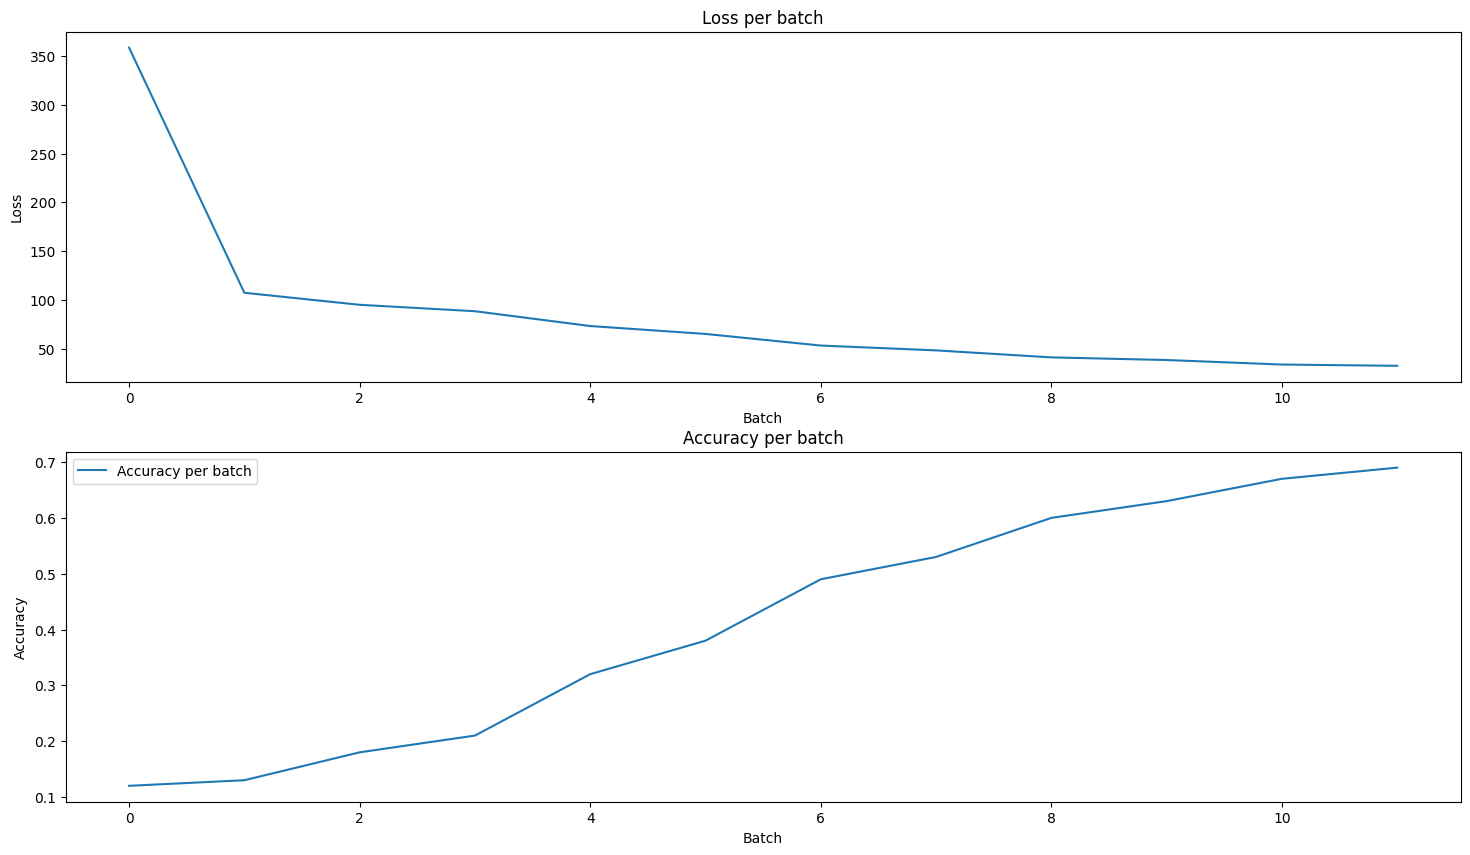

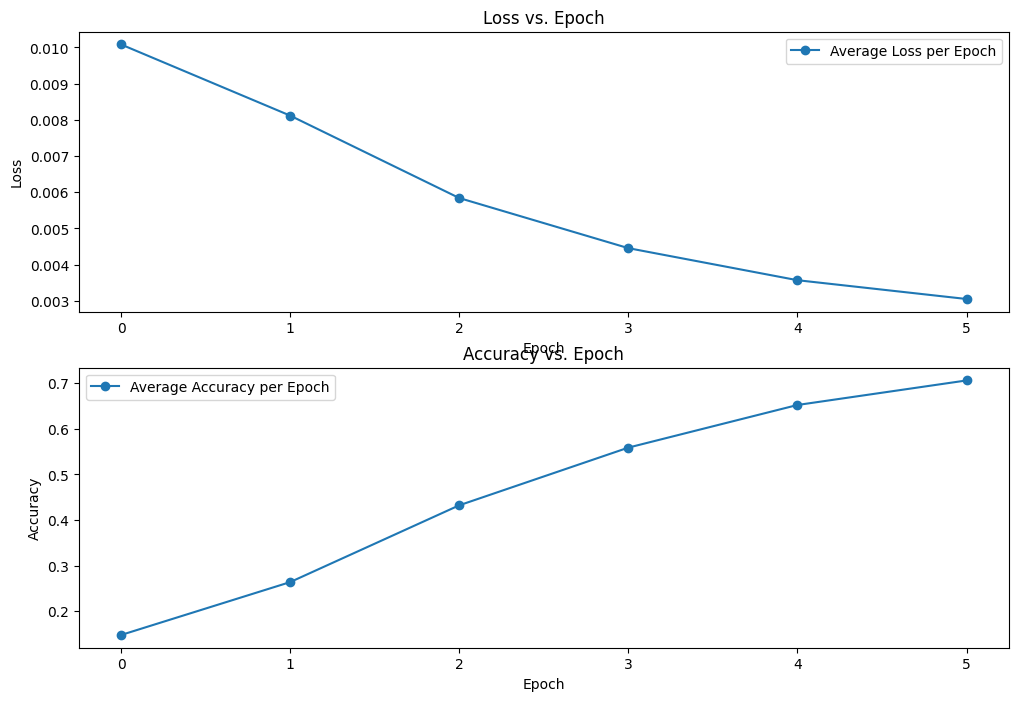

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [50, 256, 533]            --
├─Embedding: 1-1                         [50, 256, 237]            126,321
├─ModuleList: 1-6                        --                        (recursive)
│    └─BatchNorm1d: 2-1                  [256, 50, 240]            100
├─ModuleList: 1-7                        --                        (recursive)
│    └─MultiheadedAttention: 2-2         [256, 50, 240]            --
│    │    └─Dropout: 3-1                 [256, 50, 50]             --
│    │    └─Dropout: 3-2                 [256, 50, 50]             --
│    │    └─Dropout: 3-3                 [256, 50, 50]             --
│    │    └─Dropout: 3-4                 [256, 50, 50]             --
│    │    └─Dropout: 3-5                 [256, 50, 50]             --
│    │    └─Dropout: 3-6                 [256, 50, 50]             --
│    │    └─Dropout: 3-7                 [256, 50, 50]       

In [9]:
# data dict
path='/content/drive/My Drive/MIDImakeover/'
# lists for tracking performance
all_losses = []
all_accs = []
epoch_losses = []  # To track average loss per epoch
epoch_accs = []    # To track average accuracy per epoch

# load model
#m.load_state_dict(torch.load('/content/model.pt'))
# set to training mode
m.train()

# training loop
for epoch in range(6):
    # print epoch num
    print('epoch: ' + str(epoch))
    # lists for tracking performance (within epoch)
    losses = []
    accs = []
    # build dataset and dataloader
    dataset = Dataset(seq_len, 2900)
    generator = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    # initiate counter for batches trained on
    counter = 0
    for x, y in generator:
        counter += 1
        # get data ready
        x, y = x.to(device), y.float().to(device)
        opt.zero_grad()
        x = x.swapaxes(1, 0)
        y = y.swapaxes(1, 0)
        # run model
        output = m(x)
        # sample accuracy
        if counter % 5 == 0:
            accs.append(torch.sum(torch.argmax(y, axis=2) == torch.argmax(output, axis=2)) / (output.shape[0] * output.shape[1]))
        # calculate loss and update model
        loss = loss_func(output, y)
        losses.append(loss.item())
        loss.backward()
        opt.step()
        # save performance
        if counter % 100 == 0:
            print(f'[{counter}/{len(generator)}]')
            print(round(np.mean(losses) * 10000, 2), round(np.mean([x.cpu().detach().numpy() for x in accs]), 2))
            all_accs.append(round(np.mean([x.cpu().detach().numpy() for x in accs]), 2))
            all_losses.append(round(np.mean(losses) * 10000, 2))
            losses = []
            accs = []
            print()

    # Track average loss and accuracy for the epoch
    epoch_loss = np.mean(losses)
    epoch_acc = np.mean([x.cpu().detach().numpy() for x in accs]) if accs else 0
    epoch_losses.append(epoch_loss)
    epoch_accs.append(epoch_acc)

# Plot performance per batch
f, a = plt.subplots(2, 1, figsize=(18, 10))
a[0].plot(all_losses, label="Loss per batch")
a[0].set_title("Loss per batch")
a[0].set_xlabel("Batch")
a[0].set_ylabel("Loss")
a[1].plot(all_accs, label="Accuracy per batch")
a[1].set_title("Accuracy per batch")
a[1].set_xlabel("Batch")
a[1].set_ylabel("Accuracy")
plt.legend()
plt.show()

# Plot average loss and accuracy per epoch
f, b = plt.subplots(2, 1, figsize=(12, 8))
b[0].plot(range(len(epoch_losses)), epoch_losses, marker='o', label="Average Loss per Epoch")
b[0].set_title("Loss vs. Epoch")
b[0].set_xlabel("Epoch")
b[0].set_ylabel("Loss")
b[0].legend()
b[1].plot(range(len(epoch_accs)), epoch_accs, marker='o', label="Average Accuracy per Epoch")
b[1].set_title("Accuracy vs. Epoch")
b[1].set_xlabel("Epoch")
b[1].set_ylabel("Accuracy")
b[1].legend()
plt.show()

# Print the model summary
summary(m, input_size=(seq_len, batch_size), dtypes=[torch.long])

Selected MIDI file: Bobby_Helms_-_Jingle_Bell_Rock-Piano,_Piano edit.mid
(306, 88)


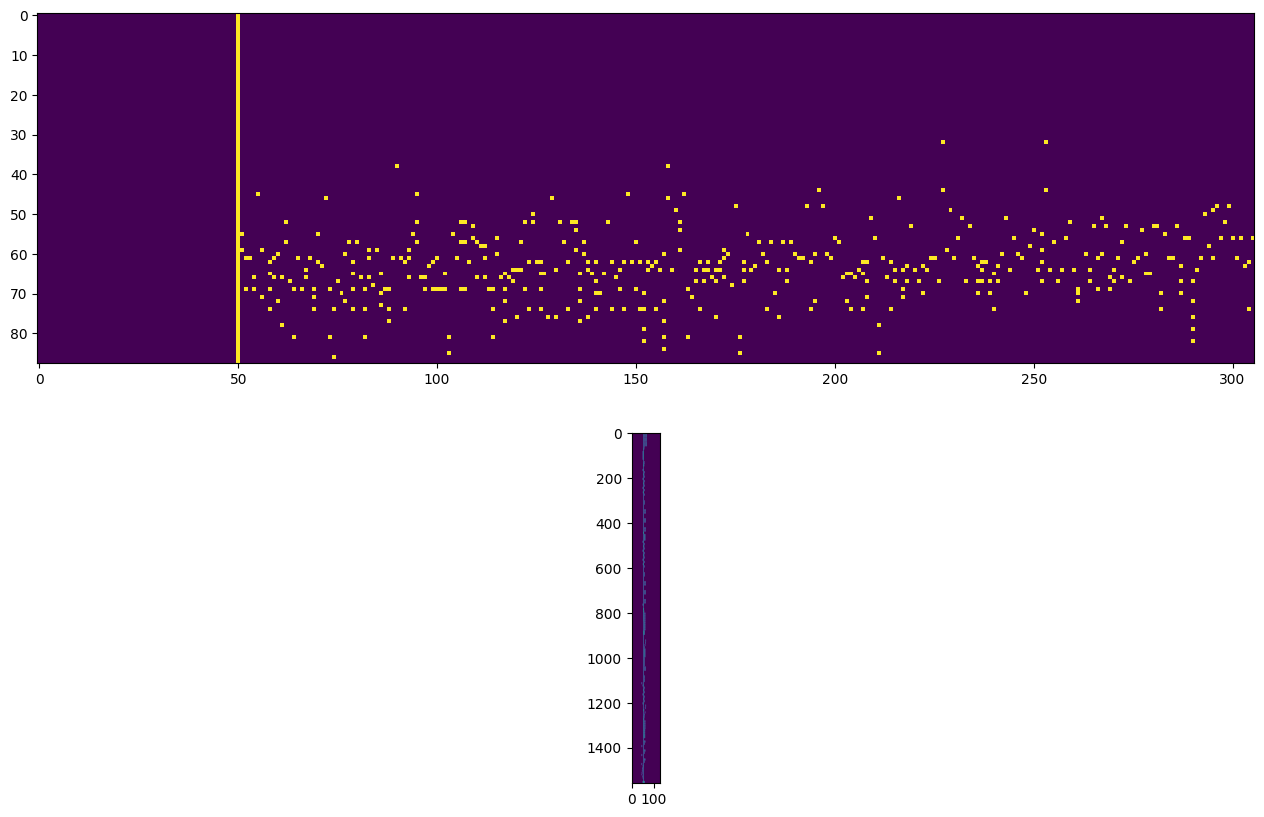

In [103]:
import random

# Randomly select a MIDI file from the MIDImakeover folder
folder_path = '/content/drive/My Drive/MIDImakeover/'
midi_files = [f for f in os.listdir(folder_path) if f.endswith('.mid')]

# Ensure there are MIDI files in the folder
if len(midi_files) == 0:
    raise FileNotFoundError("No MIDI files found in the folder!")

# Randomly select a MIDI file
selected_midi_file = random.choice(midi_files)
print(f"Selected MIDI file: {selected_midi_file}")

# Prepare musical prompt using the randomly selected file
midi_data = pretty_midi.PrettyMIDI(folder_path + selected_midi_file)
mat = midi_data.get_piano_roll(fs=20)  # Use the piano roll representation

l = list(range(len(w2i)))
# length of genreated piece
ln = int(mat.shape[0] *2)
# convert model to evaluation mode
m.eval()

def top_p_sampling(predictions, top_p):
    """
    Applies Top-p (Nucleus) Sampling to filter predictions.
    Args:
        predictions: Softmax probabilities (numpy array).
        top_p: Cumulative probability threshold.
    Returns:
        The index of the selected prediction.
    """
    # Sort predictions and their indices by descending probability
    sorted_indices = np.argsort(predictions)[::-1]
    sorted_probs = predictions[sorted_indices]

    # Compute cumulative probabilities
    cumulative_probs = np.cumsum(sorted_probs)

    # Find the cutoff where cumulative probability exceeds top_p
    cutoff_index = np.where(cumulative_probs > top_p)[0][0]

    # Retain only the predictions within the top-p range
    filtered_indices = sorted_indices[:cutoff_index + 1]
    filtered_probs = sorted_probs[:cutoff_index + 1]

    # Normalize the filtered probabilities
    filtered_probs /= np.sum(filtered_probs)

    # Sample from the filtered probabilities
    selected_index = np.random.choice(filtered_indices, p=filtered_probs)

    return selected_index


# set temprature
temp = 1.5
# generate
gen = np.zeros((seq_len, 88), dtype=int)
with torch.no_grad():
    for i in range(ln):
        # prepare data
        start = gen[-seq_len:,:]
        start[:,0:88][start[:,0:88] > 0] = 50
        start = [str([int(k) for k in j]) for j in start.tolist()]
        start = [w2i[j] for j in start]
        start = torch.tensor(start).long().to(device).unsqueeze(0)
        start = start.repeat(256,1)
        start = start.swapaxes(0,1)


        # run model
        op = m(start)
        # convert to probablities
        pred = op[-1,0,:]
        pred = pred.cpu().detach().numpy()
        pred = pred/temp
        pred = softmax(pred)

        # Penalize empty rows in sampling
        empty_row_index = w2i[str([0] * 88)]  # Index of the empty row
        pred[empty_row_index] *= 0.1  # Reduce its probability
        pred /= np.sum(pred)  # Re-normalize

        # Apply Top-p Sampling
        pred_index = top_p_sampling(pred, top_p=0.99)

        # Parse the string into a valid NumPy array
        pred_str = i2w[pred_index]
        pred_array = np.array(eval(pred_str))
        pred_array = np.expand_dims(pred_array, axis=0)

        gen = np.concatenate([gen, pred_array])


        # Add random seed reset to ensure diversity
        np.random.seed()
        # print(f"Iteration {i}, gen shape: {gen.shape}")
        # print(f"Iteration {i}, pred shape: {pred.shape}")
        # print(f"Iteration {i}, start slice:\n{start[:5]}")  # Inspect the first 5 rows




# plot generated piece
f, a = plt.subplots(2,1,figsize=(18,10))
mat[mat > 1] = 1
gen_b = gen.copy()
gen_b[gen_b > 0] = 1
gen_b[seq_len,:] = 1
mat[seq_len,:] = 1
print(gen.shape)
a[0].imshow(gen_b.T)
a[1].imshow(mat.T)





In [104]:
# convert to MIDI and save
random_tempo = random.randint(4000000, 5000000)


def arry2mid(piano_roll, file_path, tempo):
    """
    Converts a piano roll to a MIDI file and saves it.
    Args:
        piano_roll: A NumPy array where rows are time steps and columns are MIDI pitches.
        file_path: Path to save the MIDI file.
        tempo: Tempo of the MIDI file in microseconds per quarter note (default: 120 BPM = 500000).
    """
    # Create a new PrettyMIDI object
    midi = pretty_midi.PrettyMIDI(initial_tempo=60 * (10**6) / tempo)

    # Create an instrument (default to Acoustic Grand Piano)
    instrument = pretty_midi.Instrument(program=0)

    # Iterate over the piano roll
    for time, row in enumerate(piano_roll):
        for pitch, velocity in enumerate(row):
            if velocity > 0:  # If a note is played
                # Create a note and add it to the instrument
                note = pretty_midi.Note(
                    velocity=100,  # MIDI velocity (0-127)
                    pitch=pitch ,  # Map to MIDI standard pitch range
                    start= ((2*time-1) / 20),  # Convert time step to seconds (assuming fs=100)
                    end=(2*time) / 20,
                )
                instrument.notes.append(note)



    # Add the instrument to the PrettyMIDI object
    midi.instruments.append(instrument)

    # Write the MIDI file to the specified path
    midi.write(file_path)
    print(f"MIDI file saved to {file_path}")


# Convert to MIDI and save
# Add a dummy velocity column to the generated matrix
a = np.expand_dims(np.array([100] * gen.shape[0]), axis=1)
# Concatenate the velocity column to the piano roll
t = np.concatenate([gen, a], axis=1)


# Call the new arry2mid function directly
arry2mid(t, '/content/gen.mid', random_tempo)


from google.colab import files
files.download('/content/gen.mid')


MIDI file saved to /content/gen.mid


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
print("gen shape:", gen.shape)
print("gen min value:", gen.min())
print("gen max value:", gen.max())
print("gen non-zero values:", np.count_nonzero(gen))


gen shape: (562, 88)
gen min value: 0
gen max value: 50
gen non-zero values: 2035
